In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../'

/Users/joe/Documents/boulot/git/homhots/HOTS


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as matim

import os
from IPython.display import Image, SVG, HTML, display
from HOTS.ToolsMonitor import GenerateActivationMap, DisplayActivationMap
from HOTS.Event import Event, SimpleAlphabet
from HOTS.STS import STS
from HOTS.Layer import ClusteringLayer
from HOTS.ToolsMonitor import (
    DisplayImage,
    DisplaySurface3D,
    DisplaySurface2D,
    DisplayConvergence,
    DisplayPola
)
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Classifier import Classifier
from HOTS.Network import Network
from HOTS.KmeansLagorce import KmeansLagorce

# Event based cameras

## Event-based Vision: A Survey (Gallego et al. 2020 -> on zotero group /)

#### Event-based datasets with depth of the scene
- https://daniilidis-group.github.io/mvsec/
- http://atcproyectos.ugr.es/realtimeasoc/protected/evbench.html

"In contrast to standard cameras, which acquire full images at a rate specified by an external clock (e.g., 30 fps), event cameras, such as the Dynamic Vision Sensor (DVS), respond to **brightness changes** in the scene **asynchronously and independently for every pixel**. Thus, the output of an event camera is a variable datarate sequence of digital “events” or “spikes”, with each event representing a change of brightness (**log intensity**) of predefined magnitude at a pixel at a particular time."

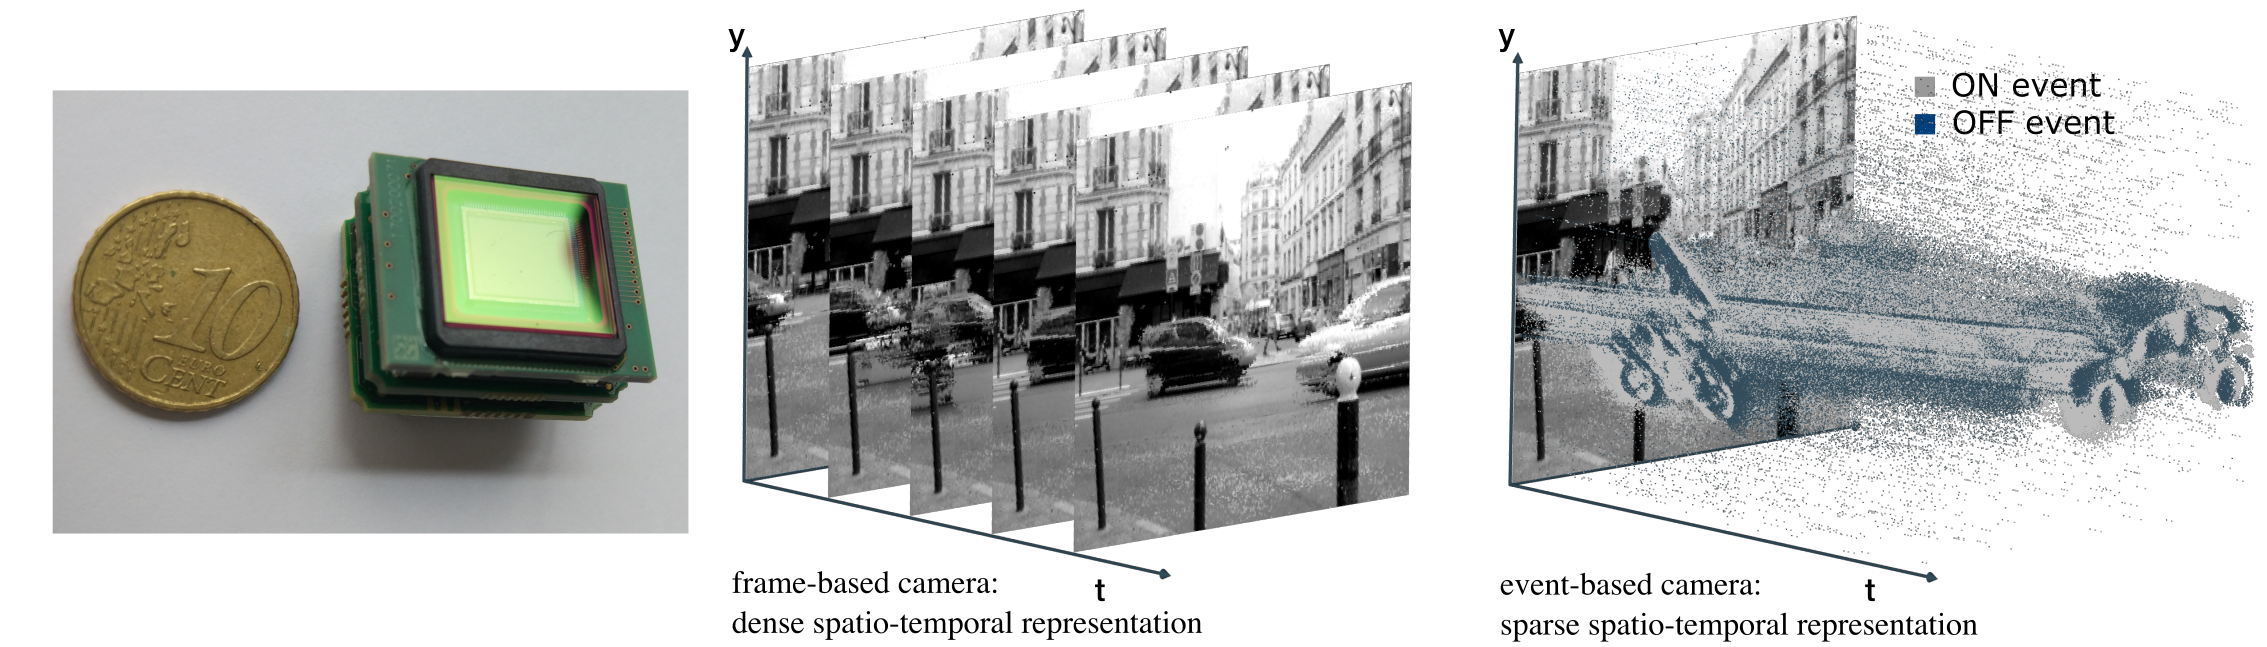

In [3]:
Image(filename='/Users/joe/Nextcloud/AgileNeuroBot/2020-05-20_AAPG2020_AgileNeuroBot/Fig/event_driven_computations.png')

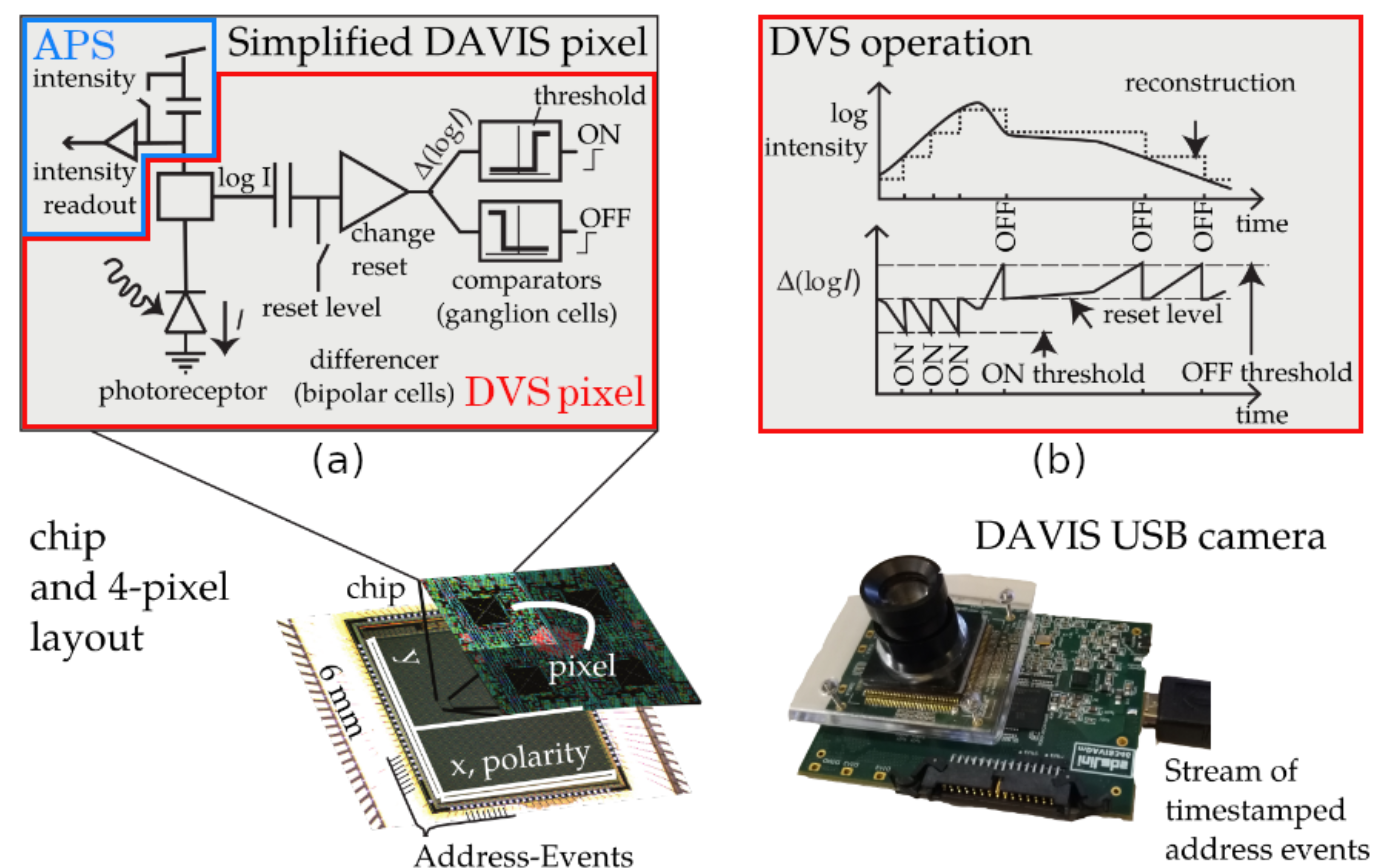

In [4]:
Image(filename='./notebooks/fig/dvssensor.png')

- "Even  when  the  LED  brightness  is  reduced  by  a  factor  of 1000,  **the  frequency  response  of  DVS  pixels  is  ten  times higher than the 30 Hz Nyquist frequency from a 60 fps image sensor**." (no motion blur)

- "**Low Latency**: each pixel works independently and there is no need to wait for a global exposure time of the frame: as soon as the change is detected, it is transmitted. Hence, event cameras have minimal latency: about 10 μs on the lab bench, and sub-millisecond in the real world."

- "**Low Power**: Because event cameras transmit only bright- ness changes, and thus remove redundant data, power is only used to process changing pixels."

- "**High Dynamic Range** (HDR): The very high dynamic range of event cameras (>120 dB) notably exceeds the 60 dB of high-quality, frame-based cameras, making them able to acquire information from moonlight to daylight. It is due to the facts that the photoreceptors of the pixels operate in logarithmic scale and each pixel works independently, not waiting for a global shutter."

- "The  incident  light  at  a  pixel  is  a  product  of  scene  illumination and surface reflectance. If illumination is approximately constant, a log intensity change signals a **reflectance change**. These  changes  in  reflectance  are  mainly  the  result of the **movement** of objects in the field of view. That is why the DVS brightness change events have a built-in **invariance to scene illumination**."

### *Biological Analogy*

"The DVS was inspired by the function of biological visual pathways, which have “transient” pathways dedicated to processing dynamic visual information in the so-called **“where” pathway**. [...] In humans, the transient pathway occupies about 30 % of the visual system. It starts with transient ganglion cells, which are mostly found in retina outside the fovea. It continues with magno layers of the thalamus and particular sublayers of area V1. It then continues to area MT and MST, which are part of the dorsal pathway where many motion selective cells are found. **The DVS corresponds to the part of the transient pathway(s) up to retinal ganglion cells.**"

# HOTS: A Hierarchy of Event-Based Time-Surfaces for Pattern Recognition (Lagorce et al. 2017 -> on zotero group /classification/)

## Event list: $ev_i = [t_i,X_i,p_i]^T$ 
where $X_i=[x_i,y_i]^T, p_i=\{-1,+1\}$

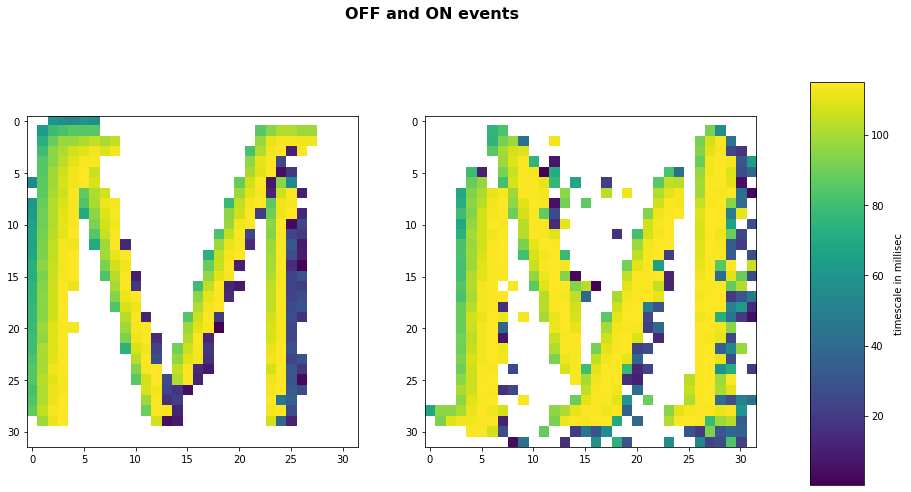

In [27]:
DataPath = "Data/alphabet_ExtractedStabilized.mat"
LabelPath = "Data/alphabet_label.pkl"
ImageSize = (32,32)
ListPolarities=[-1, 1]
nb_pola = 2
event0 = Event(ImageSize, ListPolarities)
event0.LoadFromMat("Data/alphabet_ExtractedStabilized.mat", image_number=15)
DisplayPola(event0, ImageSize, nb_pola)

## Time Surface

- Definition of a *time-context* around an incoming event $ev_i$: 
$$T_i(u,p) = max_{j\leq i}\{ t_j|X_j=X_i+u, p_j=p\}$$
where $u = [u_x,u_y]^T$ such that $u_x \in \{-R,...,R\}, u_y \in \{-R,...,R\}$

- Definition of the *time-surface*: 
$$S_i(u,p) = e^\frac{-(t_i-T_i(u,p))}{\tau}$$

Generation of SpatioTemporal Surface in ------ 0.78 s


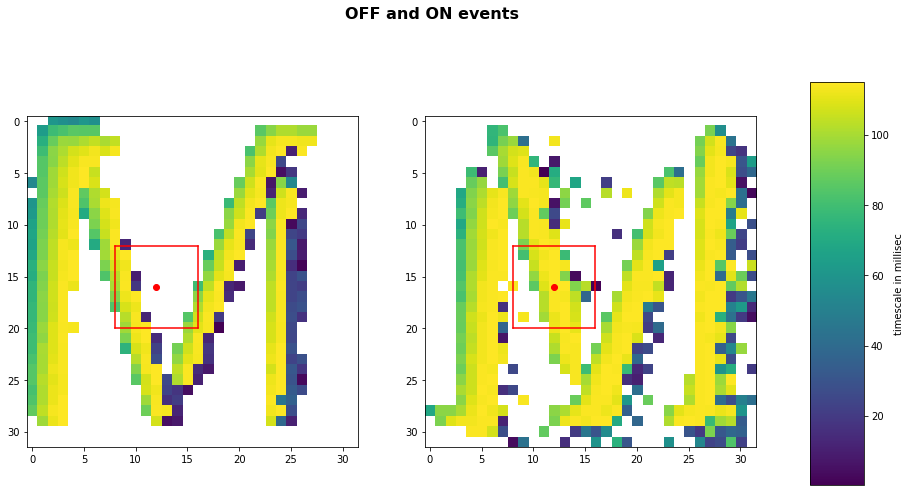

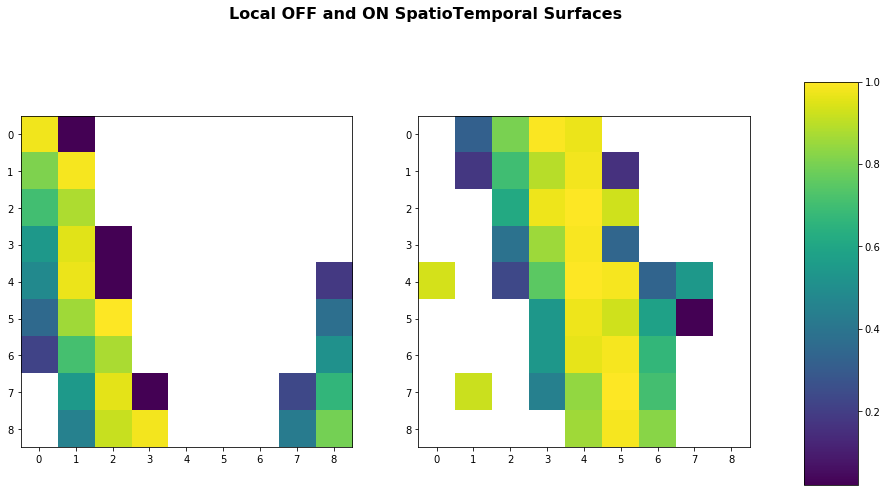

In [35]:
R = 4
tau = 0.02

SpTe = STS(tau, R, verbose=1, initial_time=0)
Surface = SpTe.create(event=event0, stop=None)

DisplayPola(event0, ImageSize, nb_pola, R, rect = True)

fig,axs = plt.subplots(1, 2, figsize=(15,8))
tsoff = np.exp(-SpTe.LocalTimeDiff[0, :, :]/tau)
tsoff[tsoff<0.005]='nan'
axs[0].imshow(tsoff)
tson = np.exp(-SpTe.LocalTimeDiff[1, :, :]/tau)
tson[tson<0.005]='nan'
br = axs[1].imshow(tson)
fig.suptitle('Local OFF and ON SpatioTemporal Surfaces', fontsize=16, fontweight='bold')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(br, cax=cbar_ax);

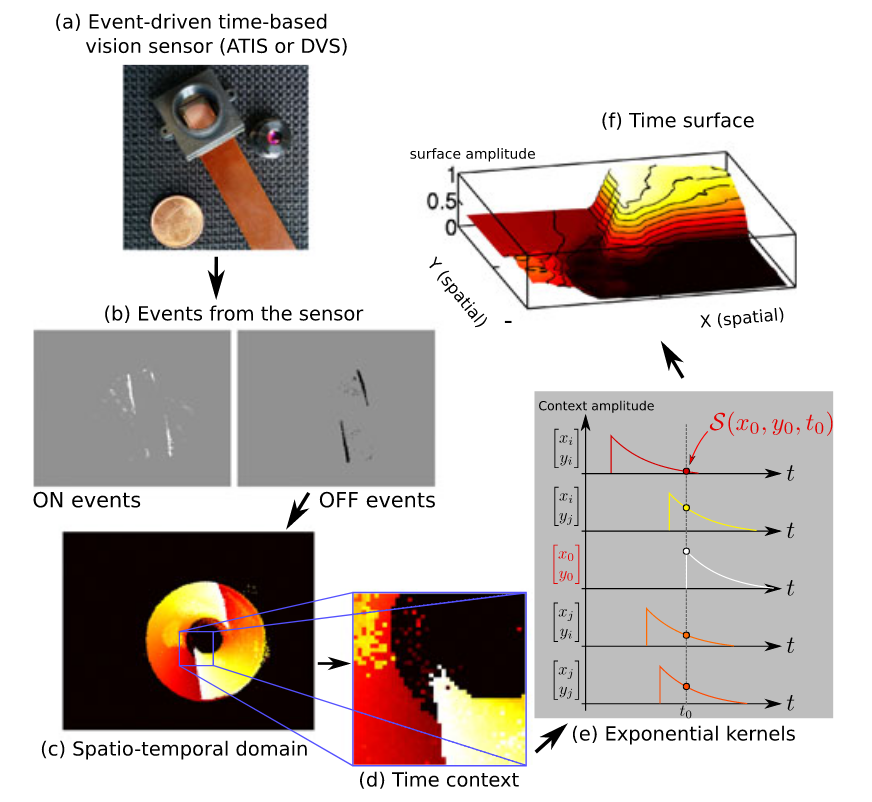

In [21]:
Image(filename='./notebooks/fig/channels.png')

### *Biological Analogy*

If we take only one channel $i$ and define $t_i$ as the last event that occured in this channel, we define the variable $S_i(t)$ as: 
$$ s_i(t)=e^\frac{-(t-t_i)}{\tau} $$ 
with $t\geq t_i$
If spikes can accumulate then, $s_i(t)$ is a solution to the equation: 
$$\tau \frac{ds_i(t)}{dt}=-s_i(t)+\delta (t-t_i)$$
In this case, the maximum value of a channel is 1 and then the differential equation describing the evolution of $s_i(t)$ is: 
$$\tau \frac{s_i(t)}{dt}=-s_i(t)+(1-s_i(t))\delta (t-t_i)$$

A good modeling of neuronal dynamics is given by the **Leaky Integrate-and-Fire (LIF) model** based on the following equation: 
$$\tau \frac{dV}{dt}=-(V-V_{rest})+RI(t)$$
where $V$ is the neuron membrane potential, $V_{rest}$ the resting potential and $RI(t)$ corresponds to the current input. 

## Hierarchical model

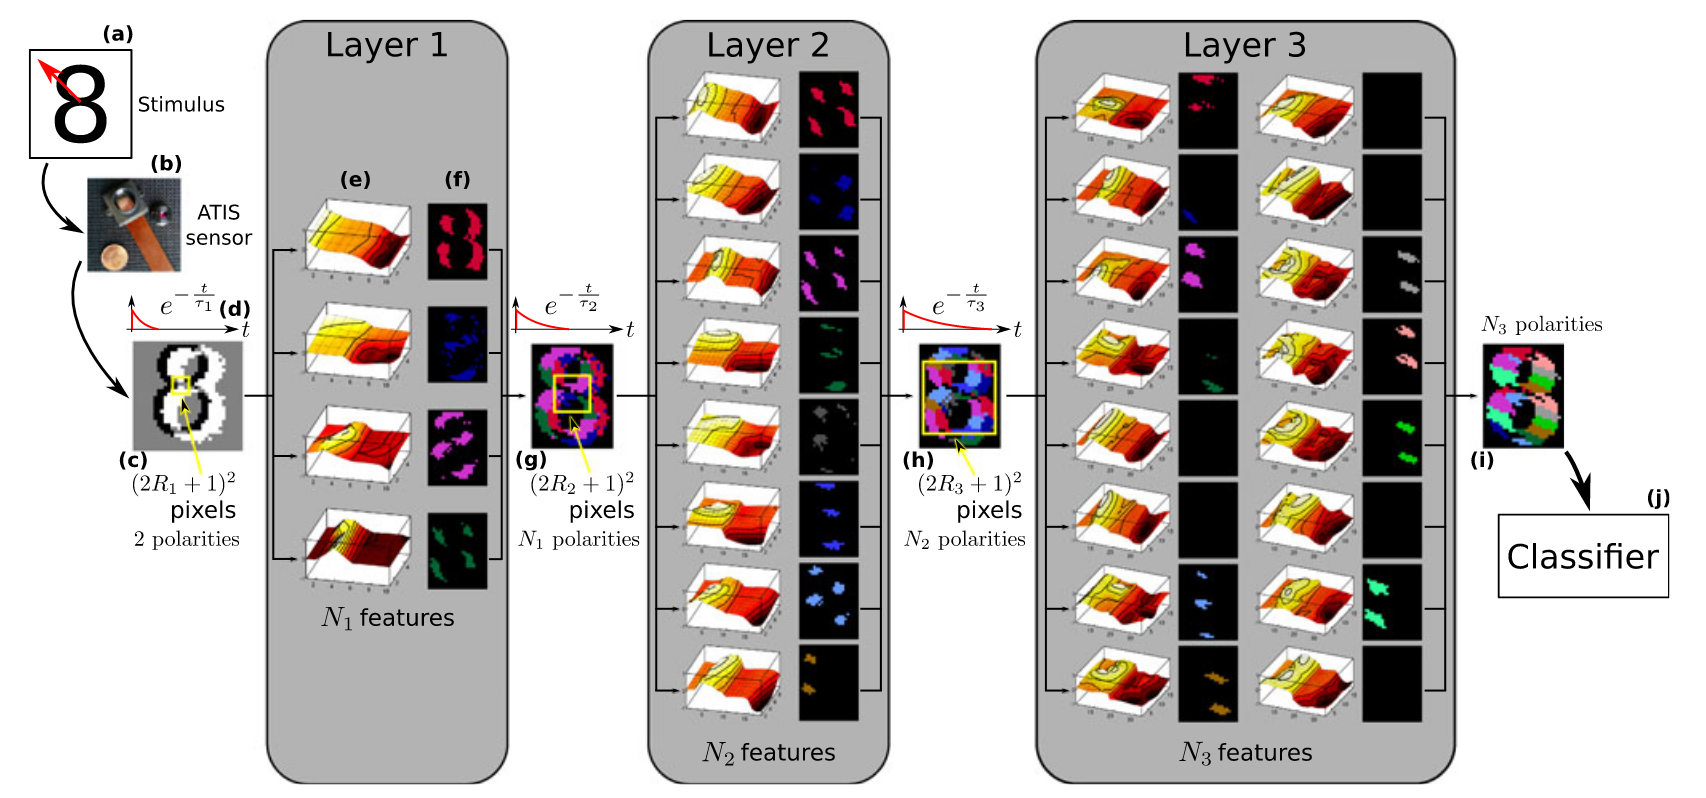

In [9]:
Image(filename='./notebooks/fig/hots.png')

In this work, the first layer of the network is composed of 4 *prototypes* taking the form of *time-surfaces*. The initialization is made with the 4 first *time-surfaces*. The input of the network is a *time-surface* and we forget about the {-1,+1} polarity for the network's input. 

Then, for each input event, the *time-surface* is matched with the closest *prototype* according to the euclidian distance: 
$$ \beta_k = \frac{\langle C_k,S_i\rangle}{\|C_k\|\|S_i\|}$$

The output of the layer is then given by a **spike emitted by the closest *prototype***. It gives a new stream of event with the same number of polarities as the number of *prototypes* in the layer. 

To build the intermediate *time-surface*, input of the next layer, the $\tau$ and $R$ parameters are increased such that $\tau_{n+1} = 10\tau_n$ and $R_{n+1} = 2R_n$. The number of *prototypes* also increase when going to the next layer: $N_{n+1} = 2N_n$

### *Biological Analogy*

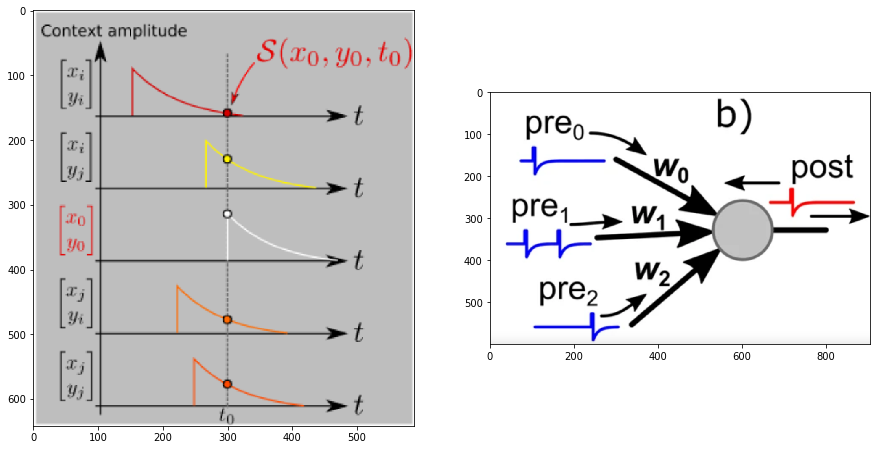

In [10]:
img_A = matim.imread('./notebooks/fig/chanhots.png');
img_B = matim.imread('./notebooks/fig/neuron.png');
fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].imshow(img_A);
ax[1].imshow(img_B);

For the prototype $k$:
$$ \beta_k(t) = \frac{\langle C_k,S_i\rangle}{\|C_k\|\|S_i\|} = \sum_{n=1}^{(2R+1)^2}s_{n}(t)c_{kn} = \sum_{n=1}^{(2R+1)^2}e^\frac{-(t_i-t_n)}{\tau}c_{kn} $$ with $n$ within the *time-surface* spatial area

The differential equation discribing the energy of the *prototype* $C_k$ with $S_i$ as input is: 
$$\tau \frac{dE_k(t)}{dt}=-E_k(t)+\sum_{j=1}^{(2R+1)^2}c_{kj}\delta (t-t_j)$$

If $c_{kj}$ are considered to be the synaptic weights for the $k^{th}$ neuron's input, then an analogy can be made with the **LIF model with multiple synapses**. 

## Learning

A learning rule is implemented when a *prototype* is matched: 

$ \beta = \frac{\langle C_k,S_i\rangle}{\|C_k\|\|S_i\|}$ and $ \alpha = \frac{0.01}{1+\frac{p_k}{2000}}$

$C_k$ &larr; $C_k + \alpha(S_i-\beta C_k)$

This learning rule comes from the HMAX model (Riesenhuber & Poggio, 1999)

### *Biological Analogy*
    
This learning of the *prototypes* can be associated with **Hebbian learning**.

## Results: Replication of HOTS algorithm

- filtering *time-surfaces* to discard isolated events (at least $kR$ active pixels in the *time-surface*, here $k=2$)
- 2 polarities as input
- learning made on 5 symbols: F, V, O, 8 and B. (3 cycles)

battacha:95.0% ### normalized:97.5% ### euclidian:97.5% ### 


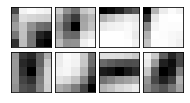

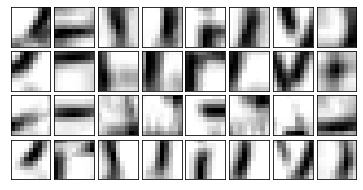

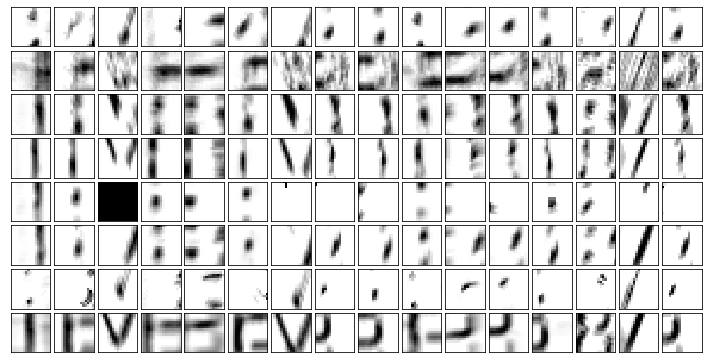

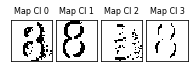

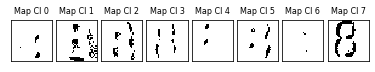

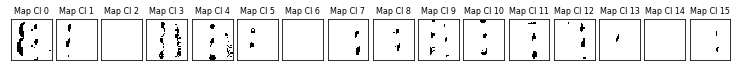

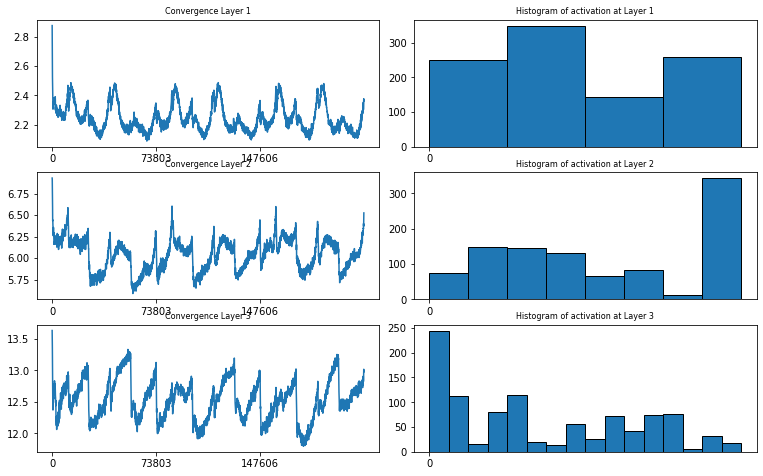

In [23]:
tau = 0.02
R = 2
nb_cluster = [4, 8, 16]
ImageSize = (32, 32)
DataPath = "Data/alphabet_ExtractedStabilized.mat"
LabelPath = "Data/alphabet_label.pkl"

event_tr, event_te, event_cl, label_tr, label_te = SimpleAlphabet(
    NbTrainingData=36,
    NbTestingData=40,
    Path=DataPath,
    LabelPath=LabelPath,
    ClusteringData=[1, 32, 19, 22, 29],
    OutOnePolarity=False,
    verbose=0,
)

fname = "Records/EXP_01_LagorceKmeans/Exp04_2020-04-17_notrdninit.pkl"
ClusterLayer, Classif0 = LoadObject(fname)
prediction, accuracy, method = Classif0.HistogramDistance(to_print=True)

DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
event_to_show = Event(ImageSize=(32, 32), ListPolarities=[-1, 1], OutOnePolarity=False)
event_to_show.LoadFromMat("Data/alphabet_ExtractedStabilized.mat", image_number=22)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer)
mapL1 = GenerateActivationMap(Net.Layers[0].output, ClusterLayer[0])
DisplayActivationMap(mapL1, scale=2)
mapL2 = GenerateActivationMap(Net.Layers[1].output, ClusterLayer[1])
DisplayActivationMap(mapL2, scale=2)
mapL3 = GenerateActivationMap(Net.Layers[2].output, ClusterLayer[2])
DisplayActivationMap(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

### Drawbacks
- grandmother neuron responses for L2 and L3
- some of the prototypes of L3 are almost never activated

# Adding homeostasis

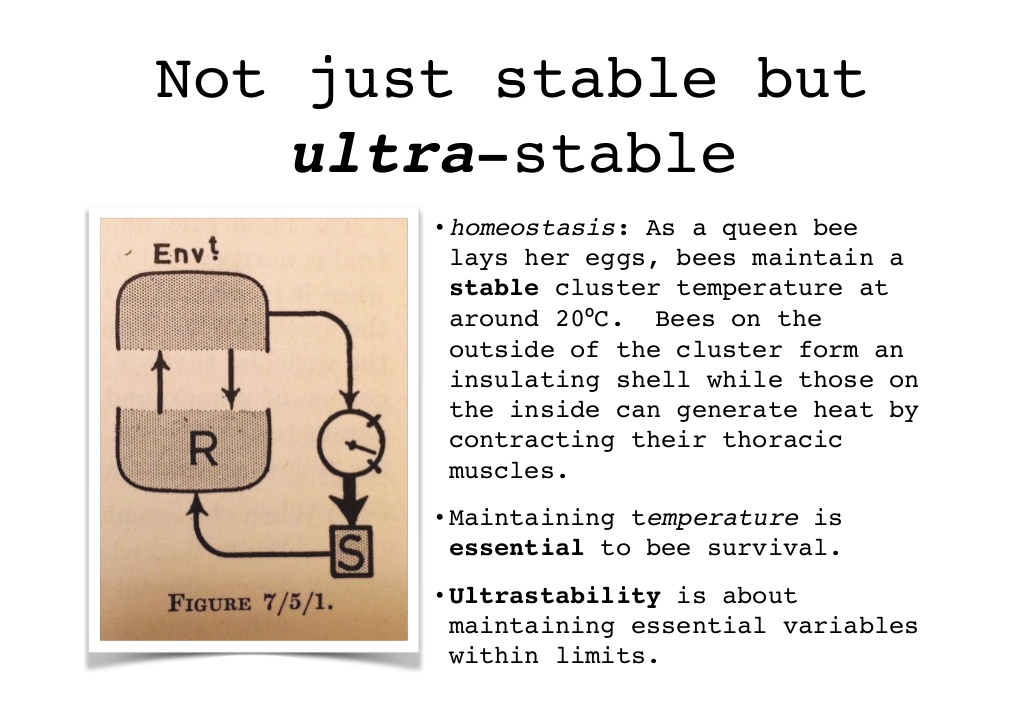

In [17]:
Image(filename='./notebooks/fig/ashby.jpg')

## Efficient Coding Hypothesis - Attneave, Barlow

"The spikes in the sensory system form a neural code for efficiently representing sensory information and that the number of spikes needed to transmit a given signal is minimized."

- Redundancy reduction and organization of the code (sparse coding)
- **Response equalization**

### *Biological Analogy*

Laughlin, 1981: Histogram equalization performed in the fly retina

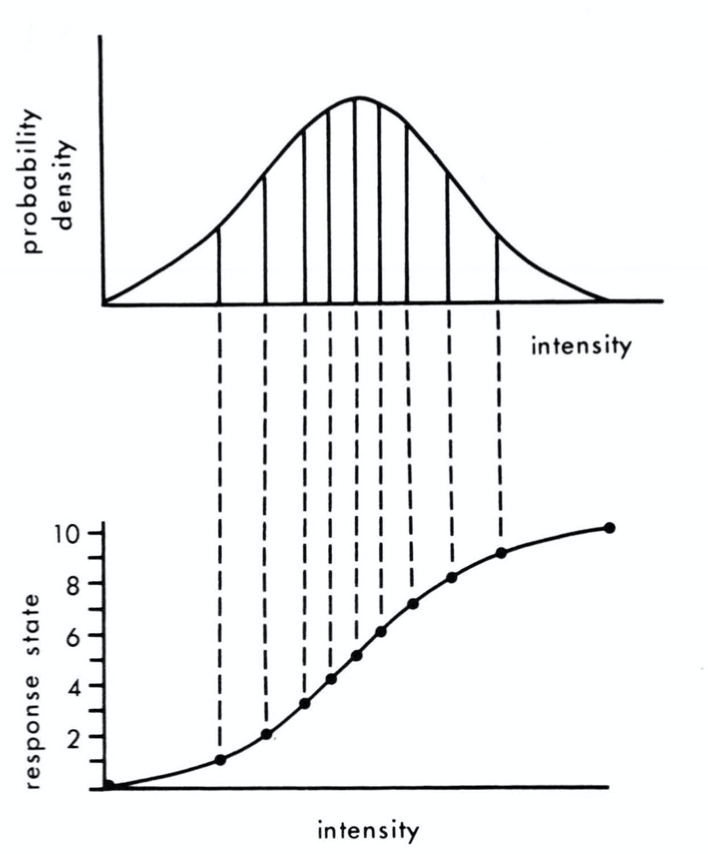

In [12]:
Image(filename='./notebooks/fig/laughlin.png', width=300)

## Results

Gain function to select the closest prototype:
$$ \gamma_k = e^{R(f_k-\frac{1}{nb_{proto}})}$$
where $f_k = \frac{\text{number of activation of prototype k}}{\text{total number of events}}$

battacha:90.0% ### normalized:90.0% ### euclidian:90.0% ### 


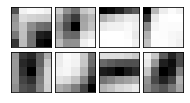

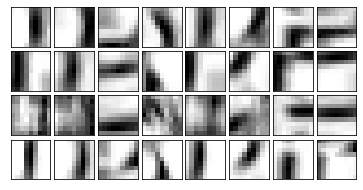

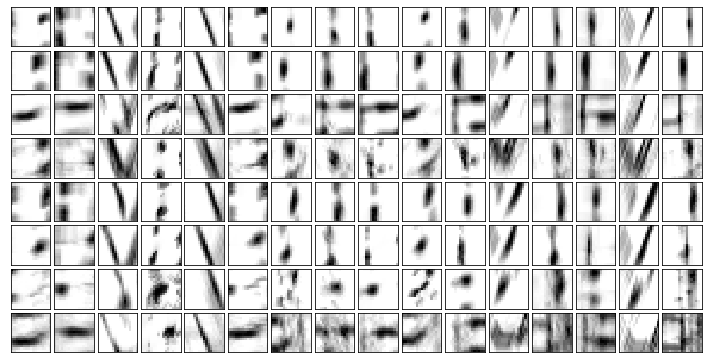

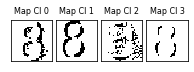

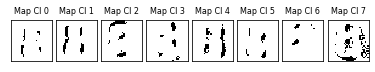

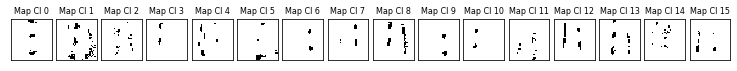

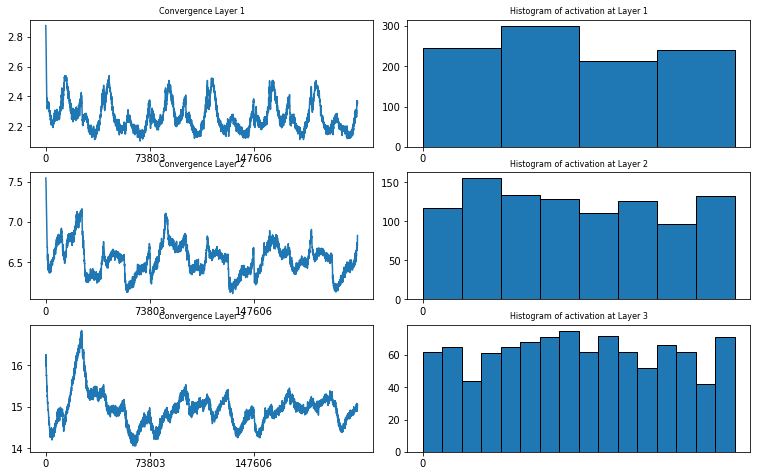

In [24]:
fname = "Records/EXP_01_LagorceKmeans/Exp04_2020-10-09_homeo_notrdninit.pkl"
ClusterLayer, Classif0 = LoadObject(fname)
prediction, accuracy, method = Classif0.HistogramDistance(to_print=True)

DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)
event_to_show = Event(ImageSize=(32, 32), ListPolarities=[-1, 1], OutOnePolarity=False)
event_to_show.LoadFromMat("Data/alphabet_ExtractedStabilized.mat", image_number=22)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer)
mapL1 = GenerateActivationMap(Net.Layers[0].output, ClusterLayer[0])
DisplayActivationMap(mapL1, scale=2)
mapL2 = GenerateActivationMap(Net.Layers[1].output, ClusterLayer[1])
DisplayActivationMap(mapL2, scale=2)
mapL3 = GenerateActivationMap(Net.Layers[2].output, ClusterLayer[2])
DisplayActivationMap(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

# Amelioration perspectives

- test on different datasets (natural images also)
- use a random initialization of the *prototypes*
- apply a gaussian mask on the *time-surfaces* to avoid edge effects

# Other contributions

- Parler du matching pursuit
    - differents outputs (1, MP coef, multiple outputs...)
    - faire un MP avec une step par event (idée du prédictif)
    - problème rencontré avec des prototypes non orthogonaux
- Idée de prédiction
    - création d'une carte de probabilité avec les events qui créent une mémoire